Importing the modules we will need for this exercise

In [1]:
import numpy as np
from pandas.plotting import scatter_matrix
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import h5py
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]
from sklearn import preprocessing
import IPython
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)

Using TensorFlow backend.


# Project data and step-by-step instructions

The goal of this project is to to detect illegitimate connections in a computer network using an **autoencoder** 

## Data set description

Data set for this project is from [The Third International Knowledge Discovery and Data Mining Tools Competition](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) at KDD-99, The Fifth International Conference on Knowledge Discovery and Data Mining. File `kddCupTrain.csv` with the data necessary for this project contains only one of multiple types of attacks (see below).  

The competition [task](http://kdd.ics.uci.edu/databases/kddcup99/task.html) was building a network intrusion detector capable of distinguishing "bad" connections, called intrusions or attacks, from "good" normal connections. This database contains a variety of intrusions simulated in a military network environment.

The original KDD training dataset consists of approximately 4,900,000 single connection vectors each of which contains 41 features and is labeled as either normal or an attack, with exactly one specific attack type. The simulated attacks fall in one of the following four categories:
1. Denial of Service Attack (DoS): is an attack in which the attacker makes some computing or memory resource too busy or too full to handle legitimate requests, or denies legitimate users access to a machine.
2. User to Root Attack (U2R): is a class in which the attacker starts out with access to a normal user account on the system (perhaps gained by sniffing passwords, a dictionary attack, or social engineering) and is able to exploit some vulnerability to gain root access to the system.
3. Remote to Local Attack (R2L): occurs when an attacker who has the ability to send packets to a machine over a network but who does not have an account on that machine exploits some vulnerability to gain local access as a user of that machine.
4. Probing Attack: is an attempt to gather information about a network of computers for the apparent purpose of circumventing its security controls.


Attacks contained in the dataset: 

Attack Category | Attack Type
--- | ---
DoS | back, land, neptune, <br>pod, smurf, teardrop
U2R | buffer_overflow, loadmodule, <br>perl, rootkit
R2L | ftp_write, guess_passwd, <br>imap, multihop, rhf, <br>spy, warezclient, warezmaster
Probe | portsweep, ipsweep, <br>satan, nmap




KDD-99 features can be classified into three groups:  
1) **Basic features**: this category encapsulates all the attributes that can be extracted from a TCP/IP connection. Most of these features leading to an implicit delay in detection.  
2) **Traffic features**: this category includes features that are computed with respect to a window interval and is divided into two groups:
* **"same host" features**: examine only the connections in the past 2 seconds that have the same destination host as the current connection, and calculate statistics related to protocol behavior, service, etc.
* **"same service" features**: examine only the connections in the past 2 seconds that have the same service as the current connection.  

These two types of "traffic" features are called time-based as opposed to the following connection-based type. 

* **"connection-based" features**: there are several types of slow probing attacks that scan the hosts (or ports) using a much larger time interval than 2 seconds, for example, one in every minute. As a result, these attacks do not produce intrusion patterns with a time window of 2 seconds. To detect such attacks the “same host” and “same service” features are  recalculated but based on the connection window of 100 connections rather than a time window of 2 seconds. These features are called **connection-based traffic features**.  

3) **Content features**: unlike most of the DoS and Probing attacks, the R2L and U2R attacks don’t have any frequent sequential intrusion patterns. This is because the DoS and Probing attacks involve many connections to some host(s) in a very short period of time. Unlike them, the R2L and U2R attacks are embedded in the data portions of the packets, and normally involve only a single connection. To detect these kinds of attacks, one needs some features in order to look for suspicious behavior in the data portion, e.g., number of failed login attempts. These features are called **content features**.

#### Table 1: Basic features of individual TCP connections.
nn | feature name |	description |	type
--:|------------|-----------|-----------
0 | duration | length (number of seconds) of the connection |	continuous
1 | protocol_type |	type of the protocol, e.g. tcp, udp, etc. |	symbolic
2 | service |	network service on the destination, e.g., http, telnet, etc. |	symbolic
3 | flag |	normal or error status of the connection |	symbolic 
4 | src_bytes |	number of data bytes from source to destination |	continuous
5 | dst_bytes |	number of data bytes from destination to source |	continuous
6 | land |	1 if connection is from/to the same host/port; 0 otherwise |	binary
7 | wrong_fragment |	number of "wrong" fragments |	continuous
8 | urgent |	number of urgent packets |	continuous

#### Table 2: Content features within a connection suggested by domain knowledge.
nn | feature name |	description |	type
---:|------------ | ------------ | --------
9 | hot |	number of "hot" indicators |	continuous
10 | num_failed_logins |	number of failed login attempts |	continuous
11 | logged_in |	1 if successfully logged in; 0 otherwise |	binary
12 | num_compromised |	number of "compromised" conditions |	continuous
13 | root_shell |	1 if root shell is obtained; 0 otherwise |	binary
14 | su_attempted |	1 if "su root" command attempted; 0 otherwise |	binary
15 | num_root |	number of "root" accesses |	continuous
16 | num_file_creations |	number of file creation operations |	continuous
17 | num_shells |	number of shell prompts |	continuous
18 | num_access_files |	number of operations on access control files |	continuous
19 | num_outbound_cmds |	number of outbound commands in an ftp session |	continuous
20 | is_hot_login |	1 if the login belongs to the "hot" list; 0 otherwise |	binary
21 | is_guest_login |	1 if the login is a "guest" login; 0 otherwise |	binary

#### Table 3: Traffic features computed using a two-second time window.
nn  | feature name |	description |	type
---:|------------ | ------------ | --------
22 | count |	number of connections to the same host as the current connection in the past two seconds |	continuous
 | | Note: The following  features refer to these same-host connections.	|
23 | serror_rate |	% of connections that have "SYN" errors |	continuous
24 | rerror_rate |	% of connections that have "REJ" errors |	continuous
25 | same_srv_rate |	% of connections to the same service |	continuous
26 | diff_srv_rate |	% of connections to different services |	continuous
27 | srv_count |	number of connections to the same service as the current connection in the past two seconds |	continuous
 |  | Note: The following features refer to these same-service connections.	|
28 | srv_serror_rate |	% of connections that have "SYN" errors |	continuous
29 | srv_rerror_rate |	% of connections that have "REJ" errors |	continuous
30 | srv_diff_host_rate |	% of connections to different hosts |	continuous
31 | dst_host_count |	number of connections from the same address to the same host as the current connection in the past two seconds |	continuous
32 | dst_host_srv_count | number of connections from the same host to the same service as the current connection in the past two seconds | continuous
 |  | Note: The following features refer to these same-host and same-service connections.	|
33 | dst_host_same_srv_rate | |	continuous
34 | dst_host_diff_srv_rate | |	continuous
35 | dst_host_same_src_port_rate | |	continuous
36 | dst_host_srv_diff_host_rate | |	continuous
37 | dst_host_serror_rate | |	continuous
38 | dst_host_srv_serror_rate | |	continuous
39 | dst_host_rerror_rate | |	continuous
40 | dst_host_srv_rerror_rate | |	continuous

The attribute labeled **41** in the data set is the **"Class"** attribute which indicates whether a given instance is a normal connection instance or an attack.

## Preparing the data set

### Reading the data set

And checking if the data set has any missing values

In [2]:
kddCupTrain = pd.read_csv('kddCupData/kddCupTrain.csv',header=None)
print("Shape of kddCupTrain: ",kddCupTrain.shape)
print("There are any missing values: ", kddCupTrain.isnull().values.any())
print(kddCupTrain.head(3))

Shape of kddCupTrain:  (985262, 42)
There are any missing values:  False
   0    1     2   3    4      5   6   7   8   9    ...     32   33   34   35  \
0   0  tcp  http  SF  215  45076   0   0   0   0   ...      0  0.0  0.0  0.0   
1   0  tcp  http  SF  162   4528   0   0   0   0   ...      1  1.0  0.0  1.0   
2   0  tcp  http  SF  236   1228   0   0   0   0   ...      2  1.0  0.0  0.5   

    36   37   38   39   40       41  
0  0.0  0.0  0.0  0.0  0.0  normal.  
1  0.0  0.0  0.0  0.0  0.0  normal.  
2  0.0  0.0  0.0  0.0  0.0  normal.  

[3 rows x 42 columns]


The train dataset contains instances of only two class types from the [original](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) data: 
- "normal." - no attack
- "ipsweep." - a subtype of "probe" or Probing Attack type.  

In [3]:
kddCupTrain.iloc[:,-1].unique()

array(['normal.', 'ipsweep.'], dtype=object)

Thus, we can see that we have to just formulate a binary classification model here, we will try to do this through auto-encoders

Rename column '41' to 'Class' and transform its values from symbolic type fo binary:  
- "normal." to 0  
- "ipsweep." to 1

In [3]:
kddCupTrain.rename(columns={41:'Class'}, inplace=True)
kddCupTrain['Class'] = np.where(kddCupTrain['Class'] == 'normal.', 0, 1)

Check counts of classes.

In [4]:
count_classes = pd.value_counts(kddCupTrain['Class'], sort = True)
print(count_classes)

0    972781
1     12481
Name: Class, dtype: int64


The dataset is highly imbalanced. Normal connections overwhelmingly outnumber fraudulent ones. 
This suggests using an autoencoder to detect attacks as rare deviations from normal.

Checking the distribution of the classes

#### Remove the uninformative columns

Look at summaries of numeric features.

In [5]:
%matlplotlib inline
print(kddCupTrain.describe(percentiles=[]))

UsageError: Line magic function `%matlplotlib` not found.


Note that some features are constant (min = max and std = 0.0). Such features are not necessary and need to be removed using

In [6]:
columnsList=[7, 19]
print(columnsList)

[7, 19]


### Removing uninformative columns below

In [7]:
kddCupTrain.drop(columnsList, axis=1, inplace=True)

#### 1.3. Transform symbolic features to "One Hot" columns

Transform character features "1", "2" and "3" into "One Hot" columns using `pandas.get_dummies()` .

As a result, the first two rows of `kddCupTrain` should look like this:  

|  0  |  4  |    5 | 6 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 20 | 21 | 22 | 23   
--|--
0 | 0 | 215 | 45076 | 0 | 0 | 0 |  0 |  1 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  1 | 1   
1 | 0 | 162 | 4528 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 2 | 2   

| 24 | 25 | 26 | 27 |  28 |  29  | 30 | 31 | 32 | 33 | 34 | 35 | 36 | 37 | 38
--|--
0|0.0 | 0.0 | 0.0 | 0.0 | 1.0 | 0.0 | 0.0 |  0 |  0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0   
1|0.0 | 0.0 | 0.0 | 0.0 | 1.0 | 0.0 | 0.0 |  1 |  1 | 1.0 | 0.0 | 1.0 | 0.0 | 0.0 | 0.0   

  | 39 | 40 | Class | 1_icmp | 1_tcp | 1_udp | 2_IRC | 2_X11 | 2_auth | 2_ctf
--|--
0 | 0.0 | 0.0 | 0 | 0 | 1 | 0 |  0  |    0  |     0  |    0   
1 | 0.0 | 0.0 | 0 | 0 | 1 | 0 |  0  |    0  |     0  |    0   

 | 2_domain | 2_domain_u | 2_eco_i | 2_ecr_i | 2_finger | 2_ftp | 2_ftp_data
 --|--
0  |   0  |    0  |   0  |  0  |   0  |    0   |   0   
1  |   0  |    0  |   0  |  0  |   0  |    0   |   0   

| 2_gopher | 2_http | 2_imap4 | 2_link | 2_mtp | 2_name | 2_ntp_u | 2_other 
--|--
0 |   0  |     1   |     0  |     0  |    0  |     0  |      0   |     0   
1 |   0  |     1   |     0  |     0  |    0  |     0  |      0   |     0   

| 2_pop_3 | 2_private | 2_red_i | 2_remote_job | 2_rje | 2_shell | 2_smtp | 2_ssh 
--|--
0 |       0 |         0 |       0 |            0 |     0 |       0 |      0 |     0   
1 |       0 |         0 |       0 |            0 |     0 |       0 |      0 |     0   

| 2_telnet | 2_tftp_u | 2_tim_i | 2_time | 2_urh_i | 2_urp_i | 2_whois | 3_OTH  
--|--
0 |        0 |     0 |       0 |      0 |       0 |       0 |       0 |     0   
1 |        0 |     0 |       0 |      0 |       0 |       0 |       0 |     0   

| 3_REJ | 3_RSTO | 3_RSTR | 3_S0 | 3_S1 | 3_S2 | 3_S3 | 3_SF | 3_SH  
--|--
0 |     0 |      0 |      0 |    0 |    0 |    0 |    0 |    1 |    0  
1 |     0 |      0 |      0 |    0 |    0 |    0 |    0 |    1 |    0  

In [8]:
kddCupTrain = pd.get_dummies(kddCupTrain, columns = [1,2,3])

In [9]:
len(list(kddCupTrain.columns.values))

84

In [10]:
list(kddCupTrain.columns.values)

[0,
 4,
 5,
 6,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 'Class',
 '1_icmp',
 '1_tcp',
 '1_udp',
 '2_IRC',
 '2_X11',
 '2_auth',
 '2_ctf',
 '2_domain',
 '2_domain_u',
 '2_eco_i',
 '2_ecr_i',
 '2_finger',
 '2_ftp',
 '2_ftp_data',
 '2_gopher',
 '2_http',
 '2_imap4',
 '2_link',
 '2_mtp',
 '2_name',
 '2_ntp_u',
 '2_other',
 '2_pop_3',
 '2_private',
 '2_red_i',
 '2_remote_job',
 '2_rje',
 '2_shell',
 '2_smtp',
 '2_ssh',
 '2_telnet',
 '2_tftp_u',
 '2_tim_i',
 '2_time',
 '2_urh_i',
 '2_urp_i',
 '2_whois',
 '3_OTH',
 '3_REJ',
 '3_RSTO',
 '3_RSTR',
 '3_S0',
 '3_S1',
 '3_S2',
 '3_S3',
 '3_SF',
 '3_SH']

In [11]:
kddCupTrain.shape

(985262, 84)

### Now, we need to standardize the data set, classify it into training and testing data set.
### Use the scaling function to scale it

In [12]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess)

In [13]:
scalingcolumn = kddCupTrain.iloc[:,0:36].columns

In [14]:
featuresList = [col for col in kddCupTrain if col != 'Class']
print('featuresList: ',featuresList)

featuresList:  [0, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, '1_icmp', '1_tcp', '1_udp', '2_IRC', '2_X11', '2_auth', '2_ctf', '2_domain', '2_domain_u', '2_eco_i', '2_ecr_i', '2_finger', '2_ftp', '2_ftp_data', '2_gopher', '2_http', '2_imap4', '2_link', '2_mtp', '2_name', '2_ntp_u', '2_other', '2_pop_3', '2_private', '2_red_i', '2_remote_job', '2_rje', '2_shell', '2_smtp', '2_ssh', '2_telnet', '2_tftp_u', '2_tim_i', '2_time', '2_urh_i', '2_urp_i', '2_whois', '3_OTH', '3_REJ', '3_RSTO', '3_RSTR', '3_S0', '3_S1', '3_S2', '3_S3', '3_SF', '3_SH']


Removing some additional columns which are not there in the test data set.

In [15]:
featuresList = [x for x in featuresList if x!='2_tftp_u']
featuresList = [x for x in featuresList if x!='3_SH']

In [16]:
scaler = preprocessing.StandardScaler()
scaler.fit(kddCupTrain[scalingcolumn]);

kddCupTrain[scalingcolumn] = scaler.transform(kddCupTrain[scalingcolumn])
kddCupTrain.head()

/Users/joshuagoldberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/joshuagoldberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


,0,4,5,6,8,9,10,11,12,13,...,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,-0.160072,-0.011332,1.231248,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,1,0
1,-0.160072,-0.011815,0.039225,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,1,0
2,-0.160072,-0.011141,-0.057788,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,1,0
3,-0.160072,-0.011168,-0.034152,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,1,0
4,-0.160072,-0.011114,-0.079601,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,1,0


In [17]:
list(kddCupTrain.columns.values)

[0,
 4,
 5,
 6,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 'Class',
 '1_icmp',
 '1_tcp',
 '1_udp',
 '2_IRC',
 '2_X11',
 '2_auth',
 '2_ctf',
 '2_domain',
 '2_domain_u',
 '2_eco_i',
 '2_ecr_i',
 '2_finger',
 '2_ftp',
 '2_ftp_data',
 '2_gopher',
 '2_http',
 '2_imap4',
 '2_link',
 '2_mtp',
 '2_name',
 '2_ntp_u',
 '2_other',
 '2_pop_3',
 '2_private',
 '2_red_i',
 '2_remote_job',
 '2_rje',
 '2_shell',
 '2_smtp',
 '2_ssh',
 '2_telnet',
 '2_tftp_u',
 '2_tim_i',
 '2_time',
 '2_urh_i',
 '2_urp_i',
 '2_whois',
 '3_OTH',
 '3_REJ',
 '3_RSTO',
 '3_RSTR',
 '3_S0',
 '3_S1',
 '3_S2',
 '3_S3',
 '3_SF',
 '3_SH']

In [18]:
kddCupTrain=kddCupTrain.drop(['2_tftp_u', '3_SH'],axis=1)
kddCupTrain.shape

(985262, 82)

### Creating the training and testing split

In [19]:
X_train_split, X_test_split = train_test_split(kddCupTrain, test_size=0.2,
                                   stratify=kddCupTrain['Class'], 
                                   random_state=RANDOM_SEED)

In [20]:
print(X_train_split.shape, X_test_split.shape)

(788209, 82) (197053, 82)


### Detach the labels from the train and the test datasets
Extract the labels from train and test data.

In [21]:
y_train = X_train_split['Class']
X_train = X_train_split.drop(['Class'], axis=1)

y_test = X_test_split['Class']
X_test = X_test_split.drop(['Class'], axis=1)
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_test.shape,', shape Y',y_test.shape)

Train: shape X (788209, 81) , shape Y (788209,)
Test: shape X (197053, 81) , shape Y (197053,)


### Select the "normal" transactions from the training data to train autoencoder on them.

In [22]:
X_trainNorm = X_train[y_train == 0]
X_trainNorm_val = X_trainNorm.values # Only values, axes labels removed. This is input for the Autoencoder
X_testNorm_val = X_test[y_test == 0].values # The validation data

In [23]:
print(y_train.shape)
print(X_train.shape)

(788209,)
(788209, 81)


In [24]:
X_trainNorm_val.shape

(778224, 81)

### Building the model

In [25]:
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 100
encoder_dim = 10

In [26]:
input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(layer1_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
norm_1 = BatchNormalization()(encoder1)
dropout_rate = 0.2  
dropout_layer1 = Dropout(rate=dropout_rate)(norm_1)  

encoder2 = Dense(encoder_dim, activation="relu")(dropout_layer1)



decoder1 = Dense(layer1_dim, activation='tanh')(encoder2)

decoder2 = Dense(input_dim, activation='linear')(decoder1)
print('input_layer: ',input_layer)
print('encoder1',encoder1)
print('encoder2',encoder2)
print('decoder1',decoder1)
print('decoder2',decoder2)

input_layer:  Tensor("input_1:0", shape=(?, 81), dtype=float32)
encoder1 Tensor("dense_1/Tanh:0", shape=(?, 100), dtype=float32)
encoder2 Tensor("dense_2/Relu:0", shape=(?, 10), dtype=float32)
decoder1 Tensor("dense_3/Tanh:0", shape=(?, 100), dtype=float32)
decoder2 Tensor("dense_4/BiasAdd:0", shape=(?, 81), dtype=float32)


In [27]:
autoencoder2 = Model(inputs=input_layer, outputs=decoder2)
autoencoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 81)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               8200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_4 (Dense)              (None, 81)                8181      
Total para

In [28]:
nb_epoch = 100
batch_size = 500

autoencoder2.compile(optimizer='adam', 
                    loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath="model2.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0) # 'patience' number of not improving epochs
history = autoencoder2.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, #tensorboard, 
                               earlystopping
                              ]).history

Train on 778224 samples, validate on 194557 samples
Epoch 1/100
778224/778224 [==============================] - 14s 18us/step - loss: 0.3268 - val_loss: 0.2158
Epoch 2/100
778224/778224 [==============================] - 13s 16us/step - loss: 0.2000 - val_loss: 0.2059
Epoch 3/100
778224/778224 [==============================] - 13s 16us/step - loss: 0.1843 - val_loss: 0.1829
Epoch 4/100
778224/778224 [==============================] - 12s 16us/step - loss: 0.1726 - val_loss: 0.1789
Epoch 5/100
778224/778224 [==============================] - 12s 16us/step - loss: 0.1691 - val_loss: 0.1774
Epoch 6/100
778224/778224 [==============================] - 13s 16us/step - loss: 0.1619 - val_loss: 0.1637
Epoch 7/100
778224/778224 [==============================] - 12s 15us/step - loss: 0.1577 - val_loss: 0.1610
Epoch 8/100
778224/778224 [==============================] - 16s 20us/step - loss: 0.1548 - val_loss: 0.1532
Epoch 9/100
778224/778224 [==============================] - 13s 17us/step -

In [30]:
### finding the minimum vaidation loss from the above algorithm and then use that optimal number of epochs
min(history['val_loss'])

0.1531591084468652

### Loading the autoencoder model 

In [31]:
autoencoder = load_model('model2.h5')

# Evaluation

Visualize the learning process.

For model 2

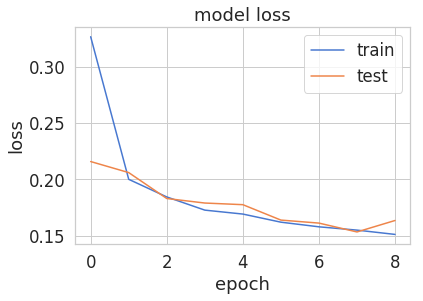

In [32]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction errors on both train and test data converge nicely. 

Calculate predictions by the autoencoder:

In [33]:
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape

((197053, 81), (197053, 81))

Calculate **mean squared error**.

In [34]:
testMSE = mean_squared_error(X_test.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error': testMSE,'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
940543,0.094102,1
356110,0.036887,0
540178,0.001869,0
672514,0.004891,0
244980,0.002400,0


In [35]:
error_df.shape

(197053, 2)

In [36]:
error_df.reconstruction_error.describe()

count    197053.000000
mean          0.131271
std          23.299513
min           0.000347
25%           0.002141
50%           0.005012
75%           0.017009
max        8290.554393
Name: reconstruction_error, dtype: float64

## Reconstruction errors for normal transactions

Plot histogram of errors of reconstruction for normal data.

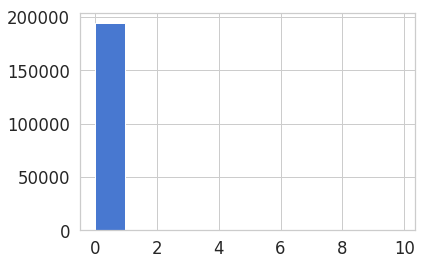

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
ax.hist(normal_error_df.reconstruction_error.values, bins=10);

## Reconstruction errors for fraudulent transactions

Compare distribution of reconstruction error for normal data and for fraudulent data.

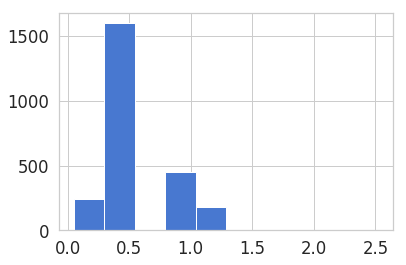

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
ax.hist(fraud_error_df.reconstruction_error.values, bins=10);

### Calculating the AUC and ROC curve

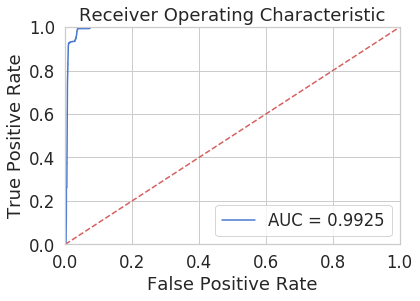

In [39]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The AUC from the above graph seems to be pretty high. 

# Prediction

To detect fraud based on prediction MSE select a high level quantile of the MSE sample that guarantees probability of type 1 error. Select 0.99 quantile of the reconstruction error for "normal" class.

In [40]:
threshold = normal_error_df.reconstruction_error.quantile(q=0.995)
threshold

0.4416375684686072

Plot all errors, normal and fraud cases marked, and the threshold:

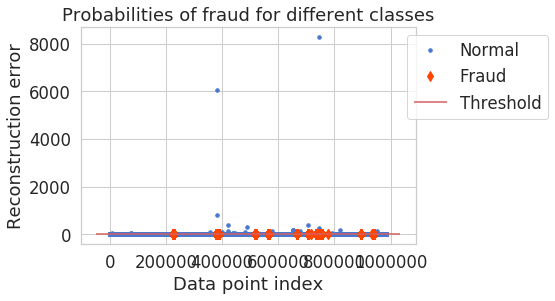

In [41]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    if name == 1:
        MarkerSize = 7
        Color = 'orangered'
        Label = 'Fraud'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.reconstruction_error, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(loc='upper left', bbox_to_anchor=(0.95, 1))
plt.title("Probabilities of fraud for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

To draw more precise conclusions calculate confusion matrix:

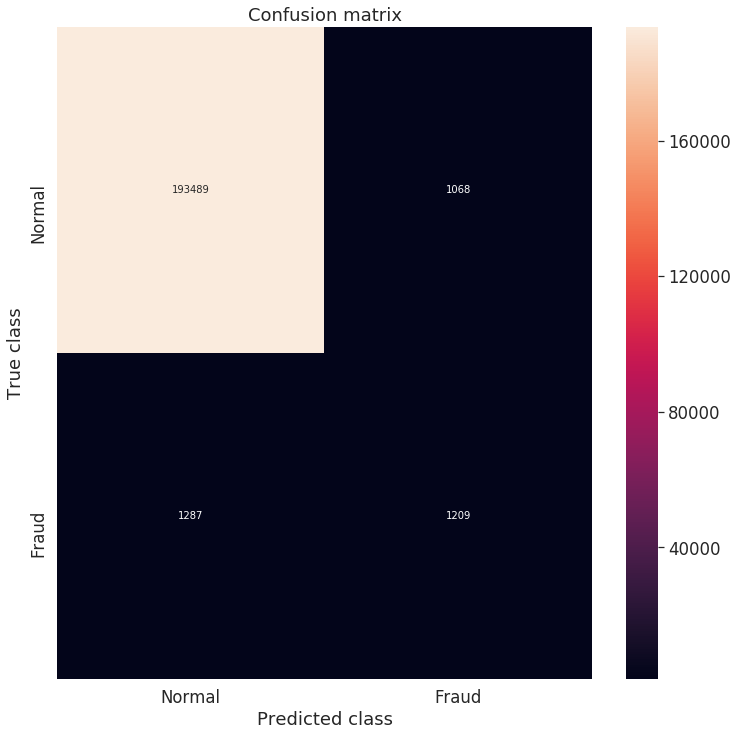

In [42]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [43]:
cohen_kappa_score(error_df.true_class, y_pred),accuracy_score(error_df.true_class, y_pred)

(0.5005637064119952, 0.9880489005495984)

The model manages to detect many fraudulent cases with accuracy over 99%. However, because of extreme prevalence Cohen's kappa gives a much more conservative evaluation. 

### Model Evaluation

Testing the model on the testing data set and then checking if the results are acceptable

In [45]:
kddCupTest = pd.read_csv("kddCupData/kddCupTest.csv", header=None)
print(kddCupTest.head(3))

   0    1        2   3     4      5   6   7   8   9  ...    31   32    33  \
0   0  tcp     http  SF   230  10066   0   0   0   0 ...   255  255  1.00   
1   0  udp  private  SF   105    145   0   0   0   0 ...   255  227  0.89   
2   1  tcp     smtp  SF  1888    374   0   0   0   0 ...   255  174  0.68   

     34   35   36   37   38   39   40  
0  0.00  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.01  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.03  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 41 columns]


In [46]:
kddCupTest.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40],
           dtype='int64')

In [47]:
kddCupTest.shape

(196557, 41)

In [48]:
##removing the uninformative columns as we did before for the training data set
kddCupTest.drop(columnsList, axis=1, inplace=True)
kddCupTest.shape

(196557, 39)

In [49]:
kddCupTest = pd.get_dummies(kddCupTest, columns = [1,2,3])
kddCupTest.head(2)
kddCupTest.shape

(196557, 106)

In [50]:
len(featuresList)

81

In [51]:
kddCupTest = kddCupTest[featuresList]

In [52]:
#we dont need to create the feature list column again.
#featuresList = [col for col in kddCupTrain if col != 'Class']
#print('featuresList: ',featuresList)

In [53]:
kddCupTest[scalingcolumn] = scaler.transform(kddCupTest[scalingcolumn])
kddCupTest.head()

/Users/joshuagoldberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


,0,4,5,6,8,9,10,11,12,13,...,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF
0,-0.160072,-0.011196,0.202030,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,0,1
1,-0.160072,-0.012334,-0.089626,-0.002665,-0.002235,-0.052816,-0.007462,-1.565399,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,0,1
2,-0.159328,0.003905,-0.082894,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,0,1
3,-0.160072,-0.010285,-0.050468,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,0,1
4,1.793586,-0.011961,-0.090802,-0.002665,-0.002235,-0.052816,-0.007462,-1.565399,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,0,1


In [54]:
kddCupTest.shape

(196557, 81)

In [55]:
kddCupTest.head()

,0,4,5,6,8,9,10,11,12,13,...,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF
0,-0.160072,-0.011196,0.202030,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,0,1
1,-0.160072,-0.012334,-0.089626,-0.002665,-0.002235,-0.052816,-0.007462,-1.565399,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,0,1
2,-0.159328,0.003905,-0.082894,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,0,1
3,-0.160072,-0.010285,-0.050468,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,0,1
4,1.793586,-0.011961,-0.090802,-0.002665,-0.002235,-0.052816,-0.007462,-1.565399,-0.004408,-0.01751,...,0,0,0,0,0,0,0,0,0,1


In [56]:
testMSE

array([0.09410205, 0.03688695, 0.00186922, ..., 0.00851469, 0.00096053,
       0.352077  ])

In [57]:
testPredictions = autoencoder2.predict(kddCupTest)

testMSE = mean_squared_error(kddCupTest.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')

In [58]:
result_df = pd.DataFrame({'reconstruction_error': testMSE})
result_df.to_csv('result.csv')

In [59]:
result_df.head(30)


,reconstruction_error
0,0.007331
1,0.002180
2,0.014003
3,0.006568
4,0.031794
5,0.002296
6,0.002334
7,0.004393
8,0.007892
9,0.002180


The second model worked perfectly for my evaluation purpose.